In [1]:
if (FALSE) {
    library(devtools)
    library(httr)
    set_config(config(ssl_verifypeer = 0L))
    options(repos=structure(c(CRAN="http://cran.rstudio.com/")))
    install.packages(c("phytools","amap","RColorBrewer","colorspace","dendextend","NMF","MASS","caper","pvclust"))
}
library(phytools)
library(amap)
library(RColorBrewer)
library(colorspace)
library(dendextend)
library(NMF)
library(MASS)
library(caper)
library(pvclust)
library(Rtsne)
library(ggplot2)
options(stringsAsFactors = FALSE)

Loading required package: ape
Loading required package: maps

---------------------
Welcome to dendextend version 1.10.0
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
Or contact: <tal.galili@gmail.com>

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------


Attaching package: ‘dendextend’

The following object is masked from ‘package:phytools’:

    untangle

The following objects are masked from ‘package:ape’:

    ladderize, rotate

The following object is masked from ‘package:stats’:

    cutree

Loading required package: pkgmaker
Loading required package: registry

Attaching package: ‘pkgmaker’

The following object is masked from ‘package:base’:

    isFALSE

Loading required package: rngtool

In [2]:
# Parameter
font_size = 8
date_sra = '2018_5_1'
date_orthofinder = 'Mar22'
norm_method = '/tpm/' # '/tpm/' or '/tmm_rpkm/'
norm_method2 = gsub('/','',norm_method)
selected_tissues = c('brain','heart','kidney','liver','ovary','testis')
dir_ensembl = '/Users/kef74yk/Dropbox_w/db/Ensembl/release-91/'
dir_curated_transcriptome = paste0(dir_ensembl, 'curated_transcriptome/')
dir_tc = paste0(dir_curated_transcriptome, date_sra, norm_method, 'tc/')
dir_uncorrected_tissue_mean = paste0(dir_curated_transcriptome, date_sra, norm_method, 'uncorrected_tissue_mean/')
dir_tissue_mean = paste0(dir_curated_transcriptome, date_sra, norm_method, 'tissue_mean/')
dir_sra = paste0(dir_curated_transcriptome, date_sra, norm_method, 'sra/')
file_outsra = paste0(dir_ensembl, 'sra/', date_sra, '/sra_table_amalgamated_', date_sra, '.tsv')
file_species_tree = paste0(dir_ensembl,'timetree/species_timetree.nwk')
wd = '/Users/kef74yk/Dropbox_p/data/04_Convergence_Duplication/20190429_tmm_normalization/'
dir_out = paste0(wd, norm_method2)
dir.create(dir_out)
setwd(dir_out)

sptree = ladderize(read.newick(file_species_tree), right=TRUE)
sp_orders = rev(sptree$tip.label)
label_orders = c()
for (tissue in selected_tissues) {
    label_orders = c(label_orders, paste(sp_orders, tissue, sep='_'))
}

dir_orthofinder = paste0(dir_ensembl, 'orthofinder/')
file_singlecopy = paste0(dir_orthofinder, 'Results_', date_orthofinder, '/SingleCopyOrthogroups.txt')
file_orthogroup = paste0(dir_orthofinder, 'Results_', date_orthofinder, '/Orthogroups.csv')
single_orthogroups = read.table(file_singlecopy, header=FALSE)$V1
df_og = read.table(file_orthogroup, header=TRUE, sep='\t', row.names=1)
df_singleog = df_og[(rownames(df_og) %in% single_orthogroups),]
for (col in 1:ncol(df_singleog)) {
    df_singleog[,col] = sub('.*_', '', df_singleog[,col])
}
num_comma = apply(df_og, MARGIN=c(1,2), FUN=function(x){stringr:::str_count(x,',')})
#df_og = NULL
spp_filled = colnames(df_singleog)
spp = sub('_', ' ', spp_filled)
cat('num selected species:', length(spp), '\n')
cat('selected species:', spp, '\n')

Warning message in dir.create(dir_out):
“'/Users/kef74yk/Dropbox_p/data/04_Convergence_Duplication/20190429_tmm_normalization/tpm' already exists”

num selected species: 21 
selected species: Anolis carolinensis Astyanax mexicanus Bos taurus Callithrix jacchus Canis lupus Chinchilla lanigera Danio rerio Gadus morhua Gallus gallus Homo sapiens Macaca mulatta Monodelphis domestica Mus musculus Oreochromis niloticus Ornithorhynchus anatinus Oryctolagus cuniculus Oryzias latipes Ovis aries Rattus norvegicus Sus scrofa Xenopus tropicalis 


In [3]:
add_color_to_sra = function(df, selected_tissues) {
    df = df[,(!colnames(df) %in% c('bp_color','sp_color','tissue_color'))]
    scientific_name = as.character(df$scientific_name)
    tissue = as.character(df$tissue)
    scientific_name_unique = scientific_name[!duplicated(scientific_name)]
    tissue_unique = tissue[!duplicated(tissue)]
    if (length(selected_tissues) <= 8) {
        tissue_color = brewer.pal(length(unique(tissue)), "Dark2")
        sp_color = rainbow_hcl(length(unique(scientific_name)), c=100)
    } else if (length(selected_tissues) <= 12) {
        tissue_color = brewer.pal(length(unique(tissue)), "Paired")
        sp_color = rainbow_hcl(length(unique(scientific_name)), c=100)
    } else {
        tissue_color = rainbow_hcl(length(selected_tissues), c=100)
        sp_color = rainbow_hcl(length(unique(scientific_name)), c=150)
    }
    df_tissue = data.frame(tissue=tissue_unique, tissue_color=tissue_color[1:length(tissue_unique)], stringsAsFactors=FALSE)
    df_sp = data.frame(scientific_name=scientific_name_unique, sp_color=sp_color[1:length(scientific_name_unique)], stringsAsFactors=FALSE)
    df = merge(df, df_sp, sort=FALSE, all.y=FALSE)
    df = merge(df, df_tissue, sort=FALSE, all.y=FALSE)
    if ('bioproject' %in% colnames(df)) {
        bioproject = as.character(df$bioproject)
        if (length(selected_tissues) <= 8) {
            bp_color = rainbow_hcl(length(unique(bioproject)), c=50)
        } else if (length(selected_tissues) <= 12) {
            bp_color = rainbow_hcl(length(unique(bioproject)), c=50)
        } else {
            bp_color = rainbow_hcl(length(unique(bioproject)), c=50)
        }
        df_bp = data.frame(bioproject=unique(bioproject), bp_color=bp_color[1:length(unique(bioproject))], stringsAsFactors=FALSE)
        df = merge(df, df_bp, sort=FALSE, all.y=FALSE)
    }
    return(df)
}

sort_labels = function(df_label, label_orders) {
    df_tmp = data.frame()
    for (lo in label_orders) {
        splits = strsplit(lo, '_')[[1]]
        scientific_name = paste(splits[1], splits[2])
        tissue = splits[3]
        df_tmp = rbind(df_tmp, df_label[(df_label$scientific_name==scientific_name)&(df_label$tissue==tissue),])
    }
    return(df_tmp)
}

sort_averaged_tc = function(tc) {
    split_colnames = strsplit(colnames(tc), "_")
    genus_names = c()
    specific_names = c()
    tissue_names = c()
    for (i in 1:length(split_colnames)) {
        genus_names = c(genus_names, split_colnames[[i]][1])
        specific_names = c(specific_names, split_colnames[[i]][2])
        tissue_names = c(tissue_names, split_colnames[[i]][3])
    }
    colname_order = order(tissue_names, genus_names, specific_names)
    tc = tc[, colname_order]
    return(tc)
}

color_children2parent = function(node) {
    if (length(node)==2) {
        child1_color = attributes(node[[1]])$edgePar[['col']]
        child2_color = attributes(node[[2]])$edgePar[['col']]
        if ((!is.null(child1_color))&(!is.null(child2_color))) {
            if (child1_color==child2_color) {
                attributes(node)$edgePar[['col']] = child1_color
            }
        }
    }
    return(node)
}

map_color = function(redundant_variables, c) {
    uniq_var = unique(redundant_variables)
    uniq_col = rainbow_hcl(length(uniq_var), c=c)
    df_unique = data.frame(var=uniq_var, col=uniq_col, stringsAsFactors=FALSE)
    df_redundant = data.frame(var=redundant_variables, order=seq(1, length(redundant_variables)), stringsAsFactors=FALSE)
    df_redundant = merge(df_redundant, df_unique, by="var", all.x=TRUE, stringsAsFactors=FALSE)
    df_redundant = df_redundant[order(df_redundant$order),]
    return(df_redundant$col)
}

draw_multisp_heatmap = function(tc, df_label) {
    tc_dist_matrix = cor(tc, method='pearson')
    tc_dist_matrix[is.na(tc_dist_matrix)] = 0
    ann_label = df_label[,c('scientific_name','tissue')]
    colnames(ann_label) = c('species', 'organ')
    sp_color = df_label$sp_color[!duplicated(df_label$sp_color)]
    sp_color = sp_color[order(df_label$scientific_name[!duplicated(df_label$scientific_name)])]
    organ_color = df_label$tissue_color[!duplicated(df_label$tissue_color)]
    organ_color = organ_color[order(df_label$tissue[!duplicated(df_label$tissue)])]
    ann_color = list(species=sp_color, organ=organ_color)
    breaks = c(0, seq(0.3, 1, 0.01))
    aheatmap(tc_dist_matrix, color="-RdYlBu2:71", Rowv=NA, Colv=NA, revC=TRUE, legend=TRUE, breaks=breaks, 
                       annCol=ann_label, annRow=ann_label, annColors=ann_color, annLegend=FALSE, labRow=NA, labCol=NA)
}

draw_multisp_dendrogram = function(tc, df_label, sra, nboot, cex.xlab, cex.yaxis, pvclust_file='pvclust.RData') {
    colnames(tc) = sub("_.*","",sub('_',' ',colnames(tc)))
    dist_fun = function(x){Dist(t(x), method='pearson')}
    if (file.exists(pvclust_file)) {
        if (file.info(pvclust_file)$size) {
            print('pvclust file found.')
            load(pvclust_file)
        }
    } else {
        print('no pvclust file found. Start bootstrapping.')
        result = pvclust(tc, method.dist=dist_fun, method.hclust="average", nboot=nboot, parallel=FALSE) # UPGMA
        save(result, file=pvclust_file)
    }
    dend = as.dendrogram(result)
    dend_colors = df_label$tissue_color[order.dendrogram(dend)]
    label_colors = df_label$sp_color[order.dendrogram(dend)]
    labels_colors(dend) = label_colors
    dend_labels <- sra$run[order.dendrogram(dend)]
    dend <- color_branches(dend, labels=dend_labels, col=dend_colors)
    dend <- set(dend, "branches_lwd", 2)
    for (i in 1:ncol(tc)) {
        dend = dendrapply(dend, color_children2parent)
    }
    par(cex=cex.xlab)
    plot(dend, las=1, yaxt='n')
    text(result, print.num=FALSE, cex=1, col.pv='black')
    par(cex=cex.yaxis)
    axis(2, las=1)
    mtext(text='Distance', side=2, line=4, cex=cex.yaxis)
    
    n = ncol(tc)
    f = 100
    tissue_unique = unique(sra$tissue)
    sp_unique = unique(sra$scientific_name)
    bp_unique = unique(sra$bioproject)
    tissue_color_unique = unique(sra$tissue_color)
    sp_color_unique = unique(sra$sp_color)
    bp_color_unique = unique(sra$bp_color)
    legend_text = c(as.character(tissue_unique), "", as.character(sp_unique), "", as.character(bp_unique))
    legend_bg = c(tissue_color_unique, "white", sp_color_unique, "white", bp_color_unique)
    legend_fg = c(rep("black", length(tissue_color_unique)), "white", rep("black", length(sp_color_unique)), "white", rep("black", length(bp_color_unique)))
    #plot.new() ; par(mar=c(0,0,0,0))
    #legend("center", legend=legend_text, cex=1, pch=22, lty=0, lwd=1, pt.bg=legend_bg, col=legend_fg)
}

draw_multisp_pca = function(tc, df_label) {
    tc_dist_matrix = cor(tc, method='pearson')
    tc_dist_matrix[is.na(tc_dist_matrix)] = 0
    set.seed(1)
    pca = prcomp(tc_dist_matrix)
    xlabel = paste0("PC 1 (", round(summary(pca)$importance[2,1]*100, digits=1), "%)")
    ylabel = paste0("PC 2 (", round(summary(pca)$importance[2,2]*100, digits=1), "%)")
    plot(pca$rotation[,1], pca$rotation[,2], pch=21, cex=2, lwd=1, bg=df_label$tissue_color, col=df_label$sp_color, xlab=xlabel, ylab=ylabel, las=1)
}

draw_multisp_mds = function(tc, df_label) {
    tc_dist_dist = Dist(t(tc), method='pearson') + 0.000000001
    tc_dist_dist[is.na(tc_dist_dist)] = 1
    set.seed(1)
    try_out = tryCatch(
        {isoMDS(tc_dist_dist, k=2, maxit=100)},
        error = function(a){return("MDS failed.")}
    )
    if (mode(try_out)=="character") {
        cat('MDS failed.\n')
        plot(c(0, 1), c(0, 1), ann = F, bty = 'n', type = 'n', xaxt = 'n', yaxt = 'n')
    } else {
        mds <- try_out
        plot(mds$points[,1], mds$points[,2], pch=21, cex=2, lwd=1, bg=df_label$tissue_color, col=df_label$sp_color, xlab="MDS dimension 1", ylab="MDS dimension 2", las=1)
    }
}

draw_multisp_tsne = function(tc, df_label) {
    perplexity = min(30, floor(ncol(tc)/4))
    set.seed(1)
    out_tsne = Rtsne(as.matrix(t(tc)), theta=0, check_duplicates=FALSE, verbose=FALSE, perplexity=perplexity, dims=2)
    try_out = tryCatch(
        {
            plot(out_tsne$Y[,1], out_tsne$Y[,2], pch=21, cex=2, lwd=1, bg=df_label$tissue_color, col=df_label$sp_color, 
                 xlab="t-SNE dimension 1", ylab="t-SNE dimension 2", las=1)
        },
        error = function(a){return("t-SNE plot failed.")}
    )
    if (mode(try_out)=="character") {
        cat('t-SNE failed.\n')
        plot(c(0, 1), c(0, 1), ann = F, bty = 'n', type = 'n', xaxt = 'n', yaxt = 'n')
    }    
  
}

draw_multisp_legend = function(df_label) {
    tissue_unique = df_label$tissue[!duplicated(df_label$tissue)]
    sp_unique = df_label$scientific_name[!duplicated(df_label$scientific_name)]
    tissue_color_unique = df_label$tissue_color[!duplicated(df_label$tissue_color)]
    sp_color_unique = df_label$sp_color[!duplicated(df_label$sp_color)]
    toumei=rgb(1,1,1,0)
    legend_text = c('Tissue', as.character(tissue_unique), "", 'Species', as.character(sp_unique))
    legend_bg = c(toumei, tissue_color_unique, toumei, toumei, rep(toumei, length(sp_color_unique)))
    legend_fg = c(toumei, rep(toumei, length(tissue_color_unique)), toumei, toumei, sp_color_unique)
    legend_pch = c(1, rep(21,length(tissue_color_unique)), 1, 1, rep(1,length(sp_color_unique)))
    legend_font = c(2, rep(1, length(tissue_color_unique)), 1, 2, rep(3, length(sp_color_unique)))
    plot.new()
    legend("right", legend=legend_text, pt.cex=1, pch=legend_pch, lty=0, lwd=2, pt.bg=legend_bg, col=legend_fg, cex=cex_axis, text.font=legend_font)

}

In [4]:
files = list.files(dir_sra)
df_sra = data.frame()
for (file in files) {
    sra_path = paste0(dir_sra, file)
    tmp_sra = read.table(sra_path, header=TRUE, sep='\t', quote='', comment.char='')
    df_sra = rbind(df_sra, tmp_sra)
}
write.table(df_sra, file_outsra, row.names=FALSE, sep='\t')

df_sra = df_sra[(df_sra$tissue %in% selected_tissues)&(df_sra$scientific_name %in% spp),]

In [5]:
tcs = list()
tcs[['uncorrected']] = list()
tcs[['corrected']] = list()
uncorrected_files = list.files(dir_uncorrected_tissue_mean)
corrected_files = list.files(dir_tissue_mean)
for (sp in spp_filled) {
    uncorrected_file = uncorrected_files[startsWith(uncorrected_files, sp)]
    corrected_file = corrected_files[startsWith(corrected_files, sp)]
    uncorrected_path = paste0(dir_uncorrected_tissue_mean, uncorrected_file)
    corrected_path = paste0(dir_tissue_mean, corrected_file)
    tcs[['uncorrected']][[sp]] = read.table(uncorrected_path, header=TRUE, row.names=1, sep='\t')
    tcs[['corrected']][[sp]] = read.table(corrected_path, header=TRUE, row.names=1, sep='\t')
}
cat('done!\n')

done!


In [6]:
# Orthogroup mean expression

ortholog = list()
ortholog[['uncorrected']] = df_singleog
ortholog[['corrected']] = df_singleog
row_names = rownames(ortholog[['corrected']])
selected_species = spp
for (d in c('uncorrected', 'corrected')) {
    cat(d, '\n')
    for (sp in spp) {
        sp_filled = sub(" ", "_", sp)
        tc = tcs[[d]][[sp_filled]]
        colnames(tc) = paste(sp_filled, colnames(tc), sep='_')
        ortholog[[d]] = merge(ortholog[[d]], tc, by.x=sp_filled, by.y="row.names", all.x=TRUE, all.y=FALSE, sort=FALSE)
    }
    num_remove_col = length(selected_species)
    ortholog[[d]] = ortholog[[d]][,-(1:num_remove_col)]
    rownames(ortholog[[d]]) = row_names
    ortholog[[d]] = sort_averaged_tc(ortholog[[d]])
    #ortholog[[d]][ortholog[[d]]<0] = 0
    ortholog[[d]] = ortholog[[d]][, label_orders]
}
cat(nrow(ortholog[[d]]), 'orthologs detected.\n')

uncorrected 
corrected 
1377 orthologs detected.


In [7]:
unaveraged_tcs = list()
unaveraged_tcs[['corrected']] = list()
corrected_files = list.files(dir_tc)
for (sp in spp_filled) {
    corrected_file = corrected_files[startsWith(corrected_files, sp)]
    corrected_path = paste0(dir_tc, corrected_file)
    unaveraged_tcs[['corrected']][[sp]] = read.table(corrected_path, header=TRUE, row.names=1, sep='\t')
}

In [8]:
# Unaveraged orthogroup extraction

t = proc.time()
orthogroup = list()
is_complete = apply(df_og!='', 1, all)
ogtmp = df_og[is_complete,]
orthogroup[['uncorrected']] = ogtmp[,NULL]
orthogroup[['corrected']] = ogtmp[,NULL]
row_names = rownames(orthogroup[['corrected']])
selected_species = spp
for (d in c('corrected')) {
    cat(d, '\n')
    for (sp in spp) {
        cat(sp, '\n')
        sp_filled = sub(" ", "_", sp)
        tc = unaveraged_tcs[[d]][[sp_filled]]
        tc2 = tc[NULL,]
        for (og in row_names) {
            genes = strsplit(ogtmp[og,sp_filled], ', ')[[1]]
            genes = sub('.*_','',genes)
            if (length(genes)==1) {
                tc2[og,] = tc[genes,]
            } else if (length(genes)>1) {
                tc2[og,] = apply(tc[genes,], 2, median)
            }
        }
        colnames(tc2) = paste(sp_filled, colnames(tc2), sep='_')
        orthogroup[[d]] = merge(orthogroup[[d]], tc2, by="row.names", all.x=TRUE, all.y=FALSE, sort=FALSE)
        rownames(orthogroup[[d]]) = orthogroup[[d]][['Row.names']]
        orthogroup[[d]][['Row.names']] = NULL
    }
    num_remove_col = length(selected_species)
    orthogroup[[d]] = orthogroup[[d]][,-(1:num_remove_col)]
    rownames(orthogroup[[d]]) = row_names
    orthogroup[[d]] = sort_averaged_tc(orthogroup[[d]])
    #orthogroup[[d]][orthogroup[[d]]<0] = 0
    #orthogroup[[d]] = orthogroup[[d]][, label_orders]
}
cat(nrow(orthogroup[[d]]), 'orthogroups detected.\n')
print(proc.time()-t)

corrected 
Anolis carolinensis 
Astyanax mexicanus 
Bos taurus 
Callithrix jacchus 
Canis lupus 
Chinchilla lanigera 
Danio rerio 
Gadus morhua 
Gallus gallus 
Homo sapiens 
Macaca mulatta 
Monodelphis domestica 
Mus musculus 
Oreochromis niloticus 
Ornithorhynchus anatinus 
Oryctolagus cuniculus 
Oryzias latipes 
Ovis aries 
Rattus norvegicus 
Sus scrofa 
Xenopus tropicalis 
6383 orthogroups detected.
    user   system  elapsed 
 898.834  145.601 1045.812 


In [9]:
# Single-copy unaveraged_ortholog extraction

unaveraged_ortholog = list()
unaveraged_ortholog[['uncorrected']] = df_singleog
unaveraged_ortholog[['corrected']] = df_singleog
row_names = rownames(unaveraged_ortholog[['corrected']])
selected_species = spp
for (d in c('corrected')) {
    cat(d, '\n')
    for (sp in spp) {
        sp_filled = sub(" ", "_", sp)
        tc = unaveraged_tcs[[d]][[sp_filled]]
        colnames(tc) = paste(sp_filled, colnames(tc), sep='_')
        unaveraged_ortholog[[d]] = merge(unaveraged_ortholog[[d]], tc, by.x=sp_filled, by.y="row.names", all.x=TRUE, all.y=FALSE, sort=FALSE)
    }
    num_remove_col = length(selected_species)
    unaveraged_ortholog[[d]] = unaveraged_ortholog[[d]][,-(1:num_remove_col)]
    rownames(unaveraged_ortholog[[d]]) = row_names
    #unaveraged_ortholog[[d]] = sort_averaged_tc(unaveraged_ortholog[[d]])
    #unaveraged_ortholog[[d]][unaveraged_ortholog[[d]]<0] = 0
    #unaveraged_ortholog[[d]] = unaveraged_ortholog[[d]][, label_orders]
}
cat(nrow(unaveraged_ortholog[[d]]), 'unaveraged_orthologs detected.\n')

corrected 
1377 unaveraged_orthologs detected.


In [10]:
cols = c('run','bioproject','tissue','scientific_name','sp_color','tissue_color','bp_color')
df_label2 = add_color_to_sra(df_sra[(df_sra$exclusion=='no'),], selected_tissues)
df_label2 =df_label2[,cols]
head(df_label2)

run,bioproject,tissue,scientific_name,sp_color,tissue_color,bp_color
SRR579556,PRJNA176589,brain,Anolis carolinensis,#FF7A9E,#1B9E77,#E495A5
SRR579552,PRJNA176589,liver,Gallus gallus,#00C852,#E7298A,#E495A5
SRR579549,PRJNA176589,heart,Mus musculus,#00CAE3,#D95F02,#E495A5
SRR579557,PRJNA176589,kidney,Anolis carolinensis,#FF7A9E,#7570B3,#E495A5
SRR579563,PRJNA176589,heart,Xenopus tropicalis,#FF73C2,#D95F02,#E495A5
SRR579551,PRJNA176589,brain,Gallus gallus,#00C852,#1B9E77,#E495A5


In [11]:
label_order = order(df_label2[['run']])
df_label2 = df_label2[label_order,]
tc_order = order(sub('.*_','',colnames(unaveraged_ortholog[['corrected']])))
unaveraged_ortholog[['corrected']] = unaveraged_ortholog[['corrected']][,tc_order]

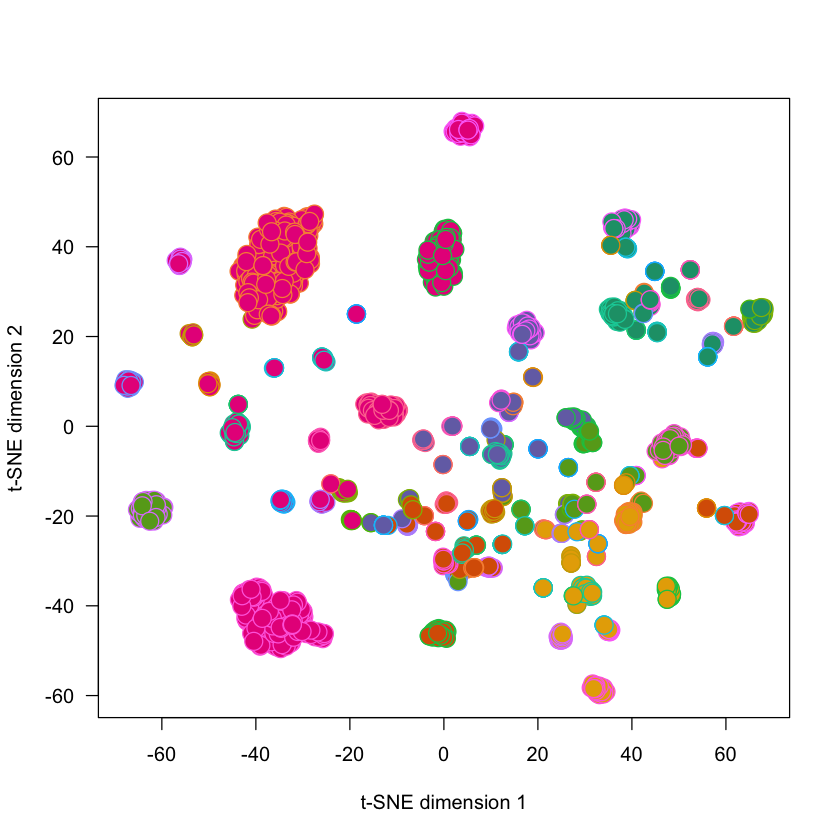

In [12]:
draw_multisp_tsne2 = function(tc, df_label) {
    perplexity = min(30, floor(ncol(tc)/4))
    set.seed(1)
    out_tsne = Rtsne(as.matrix(t(tc)), theta=0, check_duplicates=FALSE, verbose=FALSE, perplexity=perplexity, dims=2)
    try_out = tryCatch(
        {
            plot(out_tsne$Y[,1], out_tsne$Y[,2], pch=21, cex=2, lwd=1, bg=df_label$tissue_color, col=df_label$sp_color, 
                 xlab="t-SNE dimension 1", ylab="t-SNE dimension 2", las=1)
            #plot(out_tsne$Y[,1], out_tsne$Y[,2], pch=21, cex=2, lwd=1, 
            #     xlab="t-SNE dimension 1", ylab="t-SNE dimension 2", las=1)
        },
        error = function(a){return("t-SNE plot failed.")}
    )
    if (mode(try_out)=="character") {
        cat('t-SNE failed.\n')
        plot(c(0, 1), c(0, 1), ann = F, bty = 'n', type = 'n', xaxt = 'n', yaxt = 'n')
    }    
  
}

draw_multisp_tsne2(tc=unaveraged_ortholog[['corrected']], df_label=df_label2)

In [15]:
df_labels = list()
for (tpm in c('uncorrected','corrected')) {
    if (tpm=='uncorrected') {
        sra_tmp = df_sra
    } else if (tpm=='corrected') {
        sra_tmp = df_sra[(df_sra$exclusion=='no'),]
    }
    
    df_label = unique(sra_tmp[,c('scientific_name','tissue')])
    categories = list(scientific_name=sra_tmp$scientific_name, tissue=sra_tmp$tissue)

    df_bp = aggregate(sra_tmp$bioproject, by=categories, function(x){length(unique(x))})
    colnames(df_bp) = c('scientific_name','tissue','num_bp')
    df_label = merge(df_label, df_bp, all.x=TRUE, all.y=FALSE)

    df_exp = aggregate(sra_tmp$experiment, by=categories, function(x){length(unique(x))})
    colnames(df_exp) = c('scientific_name','tissue','num_exp')
    df_label = merge(df_label, df_exp, all.x=TRUE, all.y=FALSE)
    df_label = df_label[order(df_label$tissue, df_label$scientific_name),]
    df_label = sort_labels(df_label, label_orders)
    df_label = add_color_to_sra(df_label, selected_tissues)
    df_label = sort_labels(df_label, label_orders)
    df_labels[[tpm]] = df_label
}

In [37]:
get_pca_coordinates = function(tc, df_label, by='species_tissue') {
    tc_dist_matrix = cor(tc, method='pearson')
    tc_dist_matrix[is.na(tc_dist_matrix)] = 0
    #set.seed(1)
    pca = prcomp(tc_dist_matrix)
    labels = c()
    for (i in 1:5) {
        labels = c(labels, paste0("Principal component ", i, " (", round(summary(pca)$importance[2,i]*100, digits=1), "%)"))
    }
    PC1 = pca[['rotation']][,'PC1']
    PC2 = pca[['rotation']][,'PC2']
    PC3 = pca[['rotation']][,'PC3']
    PC4 = pca[['rotation']][,'PC4']
    PC5 = pca[['rotation']][,'PC5']
    tmp = data.frame(PC1, PC2, PC3, PC4, PC5)
    if (by=='species_tissue') {
        df_label[by] = paste0(sub(' ', '_', df_label[['scientific_name']]), '_', df_label[['tissue']])
        tmp[by] = rownames(tmp)
    } else if (by=='run') {
        tmp[by] = sub('.*_','',rownames(tmp))
    } else {
        tmp[by] = rownames(tmp)
    }
    tmp = merge(df_label, tmp, by=by)
    return(list(tmp, labels))
}

max_gene_per_og = 1
cat('Maximum number of genes per orthogroup =', max_gene_per_og, '\n')
preprocessing = 'no_averaging'
almost_conserved_og = apply(num_comma, 1, function(x){all((x<=max_gene_per_og-1))})
almost_conserved_og = names(almost_conserved_og)[almost_conserved_og]
tc_in = orthogroup[['corrected']]
tc_in = tc_in[(rownames(tc_in)%in%almost_conserved_og),]
#tc_in = unaveraged_ortholog[['corrected']]
dfl_in = df_label2

if (preprocessing=='no_averaging') {
    by = 'run'
} else if (preprocessing=='remove_early_diverging_taxa') {
    remove_spp = c('Astyanax mexicanus','Danio rerio','Gadus morhua','Oreochromis niloticus',
                   'Oryzias latipes','Xenopus tropicalis')
    remove_runs = dfl_in[(dfl_in[['scientific_name']]%in%remove_spp),'run']
    cat('Number of removed Runs:', length(remove_runs), '\n')
    tc_in = tc_in[,(!colnames(tc_in)%in%remove_runs)]
    dfl_in = dfl_in[(!dfl_in[['run']]%in%remove_runs),]
    by = 'run'
} else if (preprocessing=='bioproject_mean') {
    dfl_in[['bioproject']] = sub(';.*', '', dfl_in[['bioproject']])
    for (sp in unique(dfl_in[['scientific_name']])) {
        for (tissue in unique(dfl_in[['tissue']])) {
            dfl_tmp = dfl_in[(dfl_in[['scientific_name']]==sp)&(dfl_in[['tissue']]==tissue),]
            for (bp in unique(dfl_tmp[['bioproject']])) {
                key = paste0(sub(' ','_',sp), '_', tissue, '_', bp)
                runs = dfl_tmp[(dfl_tmp[['bioproject']]==bp),'run']
                cols = paste0(sub(' ','_',sp), '_', runs)
                if (length(cols)==1) {
                    mean_values = tc_in[,cols]
                } else {
                    mean_values = apply(tc_in[,cols], 1, mean)
                }
                tc_in[,cols] = NULL
                tc_in[[key]] = mean_values
            }
        }
    }
    dfl_in[['run']] = NULL
    dfl_in = unique(dfl_in)
    dfl_in[['key']] = paste0(sub(' ', '_', dfl_in[['scientific_name']]), '_', dfl_in[['tissue']], '_', dfl_in[['bioproject']])
    by='key'
} else if (preprocessing=='tissue_mean') {
    by='species_tissue'
}
out = get_pca_coordinates(tc=tc_in, df_label=dfl_in, by='run')
tmp = out[[1]]
pc_contributions = out[[2]]

cat('Number of genes/orthogroups =', nrow(tc_in), '\n')


Maximum number of genes per orthogroup = 1 
Number of genes/orthogroups = 1377 


In [38]:
for (pcxy in list(c(1,2),c(3,4))) {    
    pcx = pcxy[1]
    pcy = pcxy[2]

    colx = paste0('PC', pcx)
    coly = paste0('PC', pcy)
    xmin = min(tmp[[colx]])
    xmax = max(tmp[[colx]])
    xunit = (xmax-xmin)*0.01
    xmin = xmin - xunit
    xmax = xmax + xunit

    ymin = min(tmp[[coly]])
    ymax = max(tmp[[coly]])
    yunit = (ymax-ymin)*0.01
    ymin = ymin - yunit
    ymax = ymax + yunit

    g = ggplot(tmp, aes(tmp[[colx]], tmp[[coly]], color=tissue))
    g = g + theme_bw()
    g = g + geom_point(size=0.5)
    g = g + geom_density_2d(geom="polygon", aes(fill=tissue_color), bins=12, size=0.25)
    organ_colors = unique(df_label[,c('tissue','tissue_color')])[['tissue_color']]
    g = g + scale_color_manual(values=organ_colors)
    g = g + xlab(pc_contributions[pcx])
    g = g + ylab(pc_contributions[pcy])
    g = g + xlim(xmin, xmax)
    g = g + ylim(ymin, ymax)
    g = g + theme(
        axis.text=element_text(size=font_size), 
        axis.title=element_text(size=font_size),
        legend.text=element_text(size=font_size),
        legend.title=element_text(size=font_size)
    )
    filename = paste0('multisp_pca_', norm_method2, '_maxGenePerOG', max_gene_per_og, '_PC', pcx, pcy, '.pdf')
    ggsave(file=filename, g, height=2.15, width=4.25)
    g
}

Warning message:
“Ignoring unknown parameters: geom”Warning message:
“Ignoring unknown aesthetics: fill”Warning message:
“Ignoring unknown parameters: geom”Warning message:
“Ignoring unknown aesthetics: fill”

Warning message:
“Ignoring unknown parameters: geom”Warning message:
“Ignoring unknown aesthetics: fill”

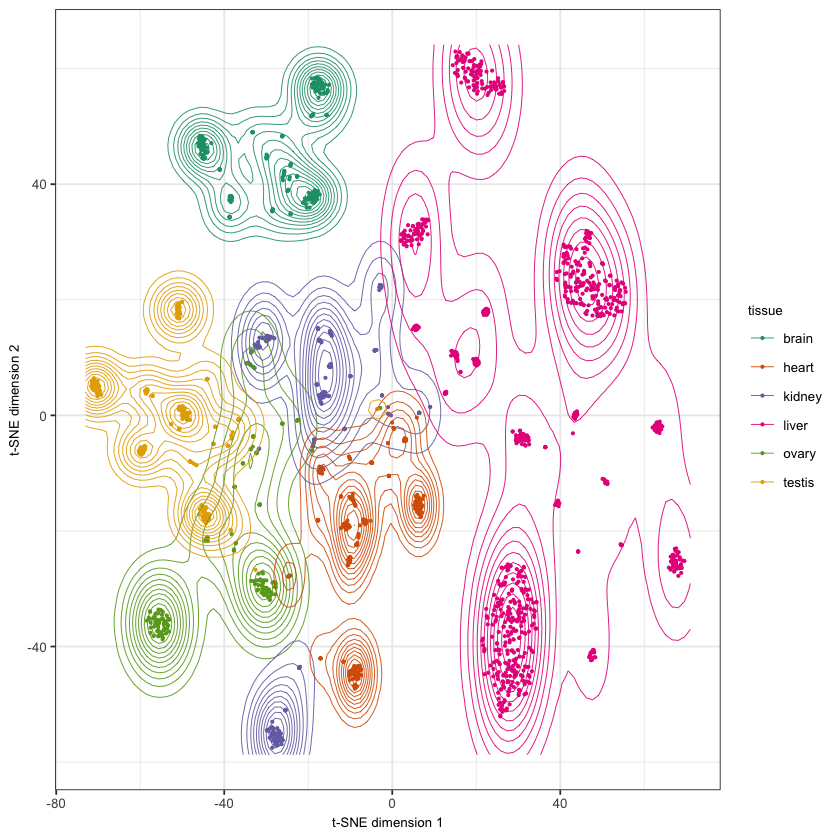

In [39]:
preprocessing = 'no_averaging'

tc_in = orthogroup[['corrected']]
tc_in = tc_in[(rownames(tc_in)%in%almost_conserved_og),]
#tc_in = unaveraged_ortholog[['corrected']]
dfl_in = df_label2

if (preprocessing=='no_averaging') {
    by = 'run'
} else if (preprocessing=='remove_early_diverging_taxa') {
    remove_spp = c('Astyanax mexicanus','Danio rerio','Gadus morhua','Oreochromis niloticus',
                   'Oryzias latipes','Xenopus tropicalis')
    remove_runs = dfl_in[(dfl_in[['scientific_name']]%in%remove_spp),'run']
    cat('Number of removed Runs:', length(remove_runs), '\n')
    tc_in = tc_in[,(!colnames(tc_in)%in%remove_runs)]
    dfl_in = dfl_in[(!dfl_in[['run']]%in%remove_runs),]
    by = 'run'
} else if (preprocessing=='bioproject_mean') {
    dfl_in[['bioproject']] = sub(';.*', '', dfl_in[['bioproject']])
    for (sp in unique(dfl_in[['scientific_name']])) {
        for (tissue in unique(dfl_in[['tissue']])) {
            dfl_tmp = dfl_in[(dfl_in[['scientific_name']]==sp)&(dfl_in[['tissue']]==tissue),]
            for (bp in unique(dfl_tmp[['bioproject']])) {
                key = paste0(sub(' ','_',sp), '_', tissue, '_', bp)
                runs = dfl_tmp[(dfl_tmp[['bioproject']]==bp),'run']
                cols = paste0(sub(' ','_',sp), '_', runs)
                if (length(cols)==1) {
                    mean_values = tc_in[,cols]
                } else {
                    mean_values = apply(tc_in[,cols], 1, mean)
                }
                tc_in[,cols] = NULL
                tc_in[[key]] = mean_values
            }
        }
    }
    dfl_in[['run']] = NULL
    dfl_in = unique(dfl_in)
    dfl_in[['key']] = paste0(sub(' ', '_', dfl_in[['scientific_name']]), '_', dfl_in[['tissue']], '_', dfl_in[['bioproject']])
    by='key'
} else if (preprocessing=='tissue_mean') {
    by='species_tissue'
}

get_tsne_coordinates = function(tc, df_label, by='run') {
    perplexity = min(30, floor(ncol(tc)/4))
    #set.seed(1)
    out_tsne = Rtsne(as.matrix(t(tc)), theta=0, check_duplicates=FALSE, verbose=FALSE, perplexity=perplexity, dims=2)
    tmp = data.frame(tsne1=out_tsne$Y[,1], tsne2=out_tsne$Y[,2])
    tmp[[by]] = sub('.*_', '', colnames(tc))
    tmp = merge(df_label, tmp, by=by)
    return(tmp)
}

tmp = get_tsne_coordinates(tc=tc_in, df_label=dfl_in)

pcx = 1
pcy = 2

colx = paste0('tsne', pcx)
coly = paste0('tsne', pcy)
xmin = min(tmp[[colx]])
xmax = max(tmp[[colx]])
xunit = (xmax-xmin)*0.01
xmin = xmin - xunit
xmax = xmax + xunit

ymin = min(tmp[[coly]])
ymax = max(tmp[[coly]])
yunit = (ymax-ymin)*0.01
ymin = ymin - yunit
ymax = ymax + yunit

g = ggplot(tmp, aes(tmp[[colx]], tmp[[coly]], color=tissue))
g = g + theme_bw()
g = g + geom_point(size=0.5)
g = g + geom_density_2d(geom="polygon", aes(fill=tissue_color), bins=12, size=0.25)
organ_colors = unique(df_label[,c('tissue','tissue_color')])[['tissue_color']]
g = g + scale_color_manual(values=organ_colors)
g = g + xlab('t-SNE dimension 1')
g = g + ylab('t-SNE dimension 2')
g = g + xlim(xmin, xmax)
g = g + ylim(ymin, ymax)
g = g + theme(
    axis.text=element_text(size=font_size), 
    axis.title=element_text(size=font_size),
    legend.text=element_text(size=font_size),
    legend.title=element_text(size=font_size)
)
filename = paste0('multisp_tsne_', norm_method2, '.pdf')
ggsave(file=filename, g, height=2.15, width=4.25)
g 

In [40]:
do_heatmap=TRUE
do_dendrogram=TRUE
do_pca_mds=TRUE

if (do_heatmap) {
    file_name='Multisp.SVA.heatmap.pdf'
    pdf(file_name, height=3.3, width=7.2) # full figure size = 9.7 x 7.2
    layout_matrix=matrix(c(
        1,2,2,2,2,2,2,2,2,2,
        1,3,3,3,3,3,3,3,3,3),
        2,10,byrow=TRUE)
    layout(t(layout_matrix))
    par(mar=c(0,0,0,0))
    plot(c(0, 1), c(0, 1), ann = F, bty = 'n', type = 'n', xaxt = 'n', yaxt = 'n')
    text(0.27,0.5,'Uncorrected', srt=0, cex=2)
    text(0.80,0.5,'Corrected', srt=0, cex=2)
    for (tpm in c('uncorrected','corrected')) {
        tc = ortholog[[tpm]]
        df_label = df_labels[[tpm]]
        par(mar=c(0,0,0,0))
        draw_multisp_heatmap(tc=tc, df_label=df_label)
    }
    graphics.off()
}

if (do_dendrogram) {
    file_name='Multisp.SVA.dendrogram.pdf'
    pdf(file_name, height=2.5, width=7.2) # full figure size = 9.7 x 7.2
    layout_matrix=matrix(c(1,2),2,1,byrow=TRUE)
    layout(t(layout_matrix))
    for (tpm in c('uncorrected','corrected')) {
        tc = ortholog[[tpm]]
        df_label = df_labels[[tpm]]
        par(cex=0.5, mar=c(10,5.5,0,0), mgp=c(4, 0.7, 0))
        pvclust_file=paste0('Multisp.pvclust.',tpm,'.RData')
        draw_multisp_dendrogram(tc=tc, df_label=df_label, sra=df_sra, pvclust_file=pvclust_file, 
                                nboot=1, cex.xlab=0.3, cex.yaxis=0.5)
    }
    graphics.off()
}

if (do_pca_mds) {
    par(cex=1)
    cex_axis=0.7
    cex_plot=1
    file_name='Multisp.SVA.PCA.MDS.pdf'
    pdf(file_name, height=4.5, width=7.2) # full figure size = 9.7 x 7.2
    layout_matrix = matrix(c(1,1,1,3,3,3,5,5,2,2,2,4,4,4,5,5),2,8,byrow=TRUE)
    layout(layout_matrix)
    for (tpm in c('uncorrected','corrected')) {
        tc = ortholog[[tpm]]
        df_label = df_labels[[tpm]]
        par(mar=c(4,4,0.1,1)); draw_multisp_pca(tc=tc, df_label=df_label)
        par(mar=c(4,4,0.1,1)); draw_multisp_tsne(tc=tc, df_label=df_label)
        #par(mar=c(4,4,0.1,1)); draw_multisp_mds(tc=tc, df_label=df_label)
    }
    par(mar=c(0,0,0,0)); draw_multisp_legend(df_label)
    graphics.off()
}


[1] "pvclust file found."
[1] "pvclust file found."


In [41]:
savefig=TRUE
do_combined=TRUE
panel_cex=1
chars = c('A','B','C','D','E','G','F','H')

if (do_combined) {
    if (savefig) {
        file_name='Multisp.SVA.combined.pdf'
        pdf(file_name, height=9.7, width=7.2) # full figure size = 9.7 x 7.2        
    }　else {
        options(repr.plot.height=9.7, repr.plot.width=7.2)
    }
    layout_matrix=matrix(c(
        1,1,1,1,2,2,2,2,
        3,3,3,3,4,4,4,4,
        3,3,3,3,4,4,4,4,
        3,3,3,3,4,4,4,4,
        3,3,3,3,4,4,4,4,
        3,3,3,3,4,4,4,4,
        3,3,3,3,4,4,4,4,
        3,3,3,3,4,4,4,4,
        3,3,3,3,4,4,4,4,
        5,5,5,5,6,6,6,6,
        5,5,5,5,6,6,6,6,
        5,5,5,5,6,6,6,6,
        5,5,5,5,6,6,6,6,
        5,5,5,5,6,6,6,6,
        5,5,5,5,6,6,6,6,
        7,7,7,9,9,9,11,11,
        7,7,7,9,9,9,11,11,
        7,7,7,9,9,9,11,11,
        7,7,7,9,9,9,11,11,
        7,7,7,9,9,9,11,11,
        7,7,7,9,9,9,11,11,
        8,8,8,10,10,10,11,11,
        8,8,8,10,10,10,11,11,
        8,8,8,10,10,10,11,11,
        8,8,8,10,10,10,11,11,
        8,8,8,10,10,10,11,11,
        8,8,8,10,10,10,11,11),
    27,8,byrow=TRUE)
    layout(layout_matrix)
    par(cex=1, xpd=T, mar=c(0,0,0,0)); plot(c(0, 1), c(0, 1), ann=F, bty='n',type='n',xaxt='n', yaxt='n')
    text(0.50,0.31,'Uncorrected', srt=0, cex=1, font=1, adj=c(0.5,1))
    text(-0.04, 0.31, chars[1], srt=0, font=2, cex=panel_cex, adj=c(0,1)) ; chars = chars[2:length(chars)]
    par(cex=1, xpd=T, mar=c(0,0,0,0)); plot(c(0, 1), c(0, 1), ann=F, bty='n',type='n',xaxt='n', yaxt='n')
    text(0.50,0.31,'Corrected', srt=0, cex=1, font=1, adj=c(0.5,1))
    text(-0.04, 0.31, chars[1], srt=0, font=2, cex=panel_cex, adj=c(0,1)) ; chars = chars[2:length(chars)]
    for (tpm in c('uncorrected','corrected')) {
        tc = ortholog[[tpm]]
        df_label = df_labels[[tpm]]
        par(mar=c(0,0,0,0))
        draw_multisp_heatmap(tc=tc, df_label=df_label)
        text(0.01, 0.93, 'Sp', srt=90, font=1, cex=0.7)
        text(0.05, 0.93, 'Tis', srt=90, font=1, cex=0.7)
        text(0.805, 0.97, 'Sp', srt=0, font=1, cex=0.7)
        text(0.805, 0.93, 'Tis', srt=0, font=1, cex=0.7)
    }
    for (tpm in c('uncorrected','corrected')) {
        tc = ortholog[[tpm]]
        df_label = df_labels[[tpm]]
        par(cex=0.5, mar=c(11,5.5,0,0), mgp=c(4, 0.7, 0))
        pvclust_file=paste0('Multisp.pvclust.',tpm,'.RData')
        draw_multisp_dendrogram(tc=tc, df_label=df_label, sra=df_sra, pvclust_file=pvclust_file, nboot=1000, cex.xlab=0.3, cex.yaxis=0.5)
        par(new=T, cex=1, xpd=T, mar=c(0,0,0,0)); plot(c(0, 1), c(0, 1), ann=F, bty='n',type='n',xaxt='n', yaxt='n')
        text(-0.04, 1.03, chars[1], srt=0, font=2, cex=panel_cex, adj=c(0,1)) ; chars = chars[2:length(chars)]
    }
    par(mar=c(0,0,0,0))
    for (tpm in c('uncorrected','corrected')) {
        tc = ortholog[[tpm]]
        df_label = df_labels[[tpm]]
        par(mar=c(4,4,0.1,1)); draw_multisp_pca(tc=tc, df_label=df_label)
        par(new=T, cex=1, xpd=T, mar=c(0,0,0,0)); plot(c(0, 1), c(0, 1), ann=F, bty='n',type='n',xaxt='n', yaxt='n')
        text(-0.04, 1.03, chars[1], srt=0, font=2, cex=panel_cex, adj=c(0,1)) ; chars = chars[2:length(chars)]
        par(mar=c(4,4,0.1,1)); draw_multisp_tsne(tc=tc, df_label=df_label)
        par(new=T, cex=1, xpd=T, mar=c(0,0,0,0)); plot(c(0, 1), c(0, 1), ann=F, bty='n',type='n',xaxt='n', yaxt='n')
        text(-0.04, 1.03, chars[1], srt=0, font=2, cex=panel_cex, adj=c(0,1)) ; chars = chars[2:length(chars)]
    }
    par(mar=c(0,0,0,0), xpd=T); draw_multisp_legend(df_label)
    if (savefig) {
        graphics.off()
    }
}

print('Completed!')

[1] "pvclust file found."
[1] "pvclust file found."
[1] "Completed!"


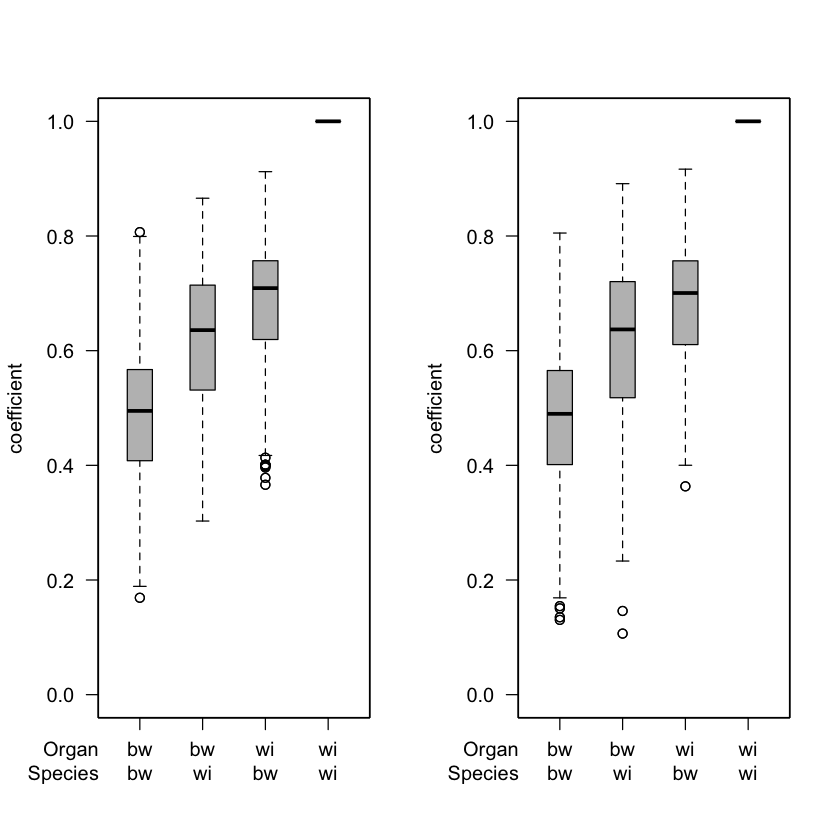

In [42]:
draw_multisp_boxplot = function(sra, tc_dist_matrix, fontsize=7) {
    is_same_sp = outer(sra$scientific_name, sra$scientific_name, function(x,y){x==y})
    is_same_tissue = outer(sra$tissue, sra$tissue, function(x,y){x==y})
    plot(c(0.5, 4.5), c(0, 1), type = 'n', xlab='', ylab="Pearson's correlation\ncoefficient", las=1, xaxt='n')
    boxplot(tc_dist_matrix[(!is_same_sp)&(!is_same_tissue)], at=1, add=TRUE, col='gray', yaxt='n')
    boxplot(tc_dist_matrix[(is_same_sp)&(!is_same_tissue)], at=2, add=TRUE, col='gray', yaxt='n')
    boxplot(tc_dist_matrix[(!is_same_sp)&(is_same_tissue)], at=3, add=TRUE, col='gray', yaxt='n')
    boxplot(tc_dist_matrix[(is_same_sp)&(is_same_tissue)], at=4, add=TRUE, col='gray', yaxt='n')
    labels = c('bw\nbw', 'bw\nwi', 'wi\nbw', 'wi\nwi')
    axis(side=1, at=c(1,2,3,4), labels=labels, padj=0.5)
    axis(side=1, at=0.35, labels='Organ\nSpecies', padj=0.5, hadj=1, tick=FALSE)

}

par(mfrow=c(1,2))
for (tpm in c('uncorrected','corrected')) {
    tc = ortholog[[tpm]]
    tc[tc<0] = 0
    tc_dist_matrix = cor(tc, method='pearson')
    tc_dist_matrix[is.na(tc_dist_matrix)] = 0
    draw_multisp_boxplot(df_labels[[tpm]], tc_dist_matrix, fontsize=7)
}

In [43]:
file_name='Multisp.SVA.t-SNE.pdf'
pdf(file_name, height=2, width=2.5) # full figure size = 9.7 x 7.2       
tpm = 'corrected'
tc = ortholog[[tpm]]
df_label = df_labels[[tpm]]
par(mar=c(2.5,2.5,0.3,0.1), cex=1, ps=8, mgp=c(1.5, 0.7, 0)); draw_multisp_tsne(tc=tc, df_label=df_label)
dev.off()

pdf 
  2